# Trading Strategies

Let's start with a classic and simple trading strategy: the moving average crossover. The idea behind this strategy is to buy a stock when its fast simple moving average (SMA) crosses above its slow SMA and to short it when the fast SMA crosses below the slow SMA.

Let's start with our imports in the cell below, and preparing our data frame in the cell below that.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

This time we'll fetch our data directly from yfinance.

In [2]:
import yfinance as yf

# df = yf.download("JPM",start="2020-01-01", end="2023-06-30")
# df
## The manual way
df = pd.read_csv("data/JPM_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index().drop_duplicates()


## Compute and Plot SMAs

Before we can implement our strategy, we need to calculate the fast (short-term) and slow (long-term) SMAs. For this example, we'll use 60-day and 80-day SMAs.

In [3]:
fast = 60
slow =  80

df["FastSMA"] = df.Close.rolling(window=fast).mean()
df["SlowSMA"] = df.Close.rolling(window=slow).mean()
df

,Open,High,Low,Close,Adj Close,Volume,FastSMA,SlowSMA
Date,,,,,,,,
2020-01-02,139.789993,141.100006,139.259995,141.089996,126.807808,10803700,NaN,NaN
2020-01-03,137.500000,139.229996,137.080002,138.339996,125.134415,10386800,NaN,NaN
2020-01-06,136.559998,138.270004,136.500000,138.229996,125.034927,10259000,NaN,NaN
2020-01-07,137.279999,137.860001,135.820007,135.880005,122.909264,10531300,NaN,NaN
2020-01-08,135.699997,137.580002,135.600006,136.940002,123.868065,9695300,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-06-05,140.110001,140.110001,138.130005,139.089996,139.089996,8511900,134.202833,135.855250
2023-06-06,138.679993,140.100006,138.210007,139.339996,139.339996,9329500,134.297667,135.841750
2023-06-07,139.550003,141.270004,138.830002,140.690002,140.690002,9281400,134.455000,135.837375



Remember we'll have a window-length of NaNs in our data frame. This is because we don't have enough data points to calculate an N-day moving average until the Nth day. 
Let's plot the closing price with the SMAs to visually inspect the crossover points.

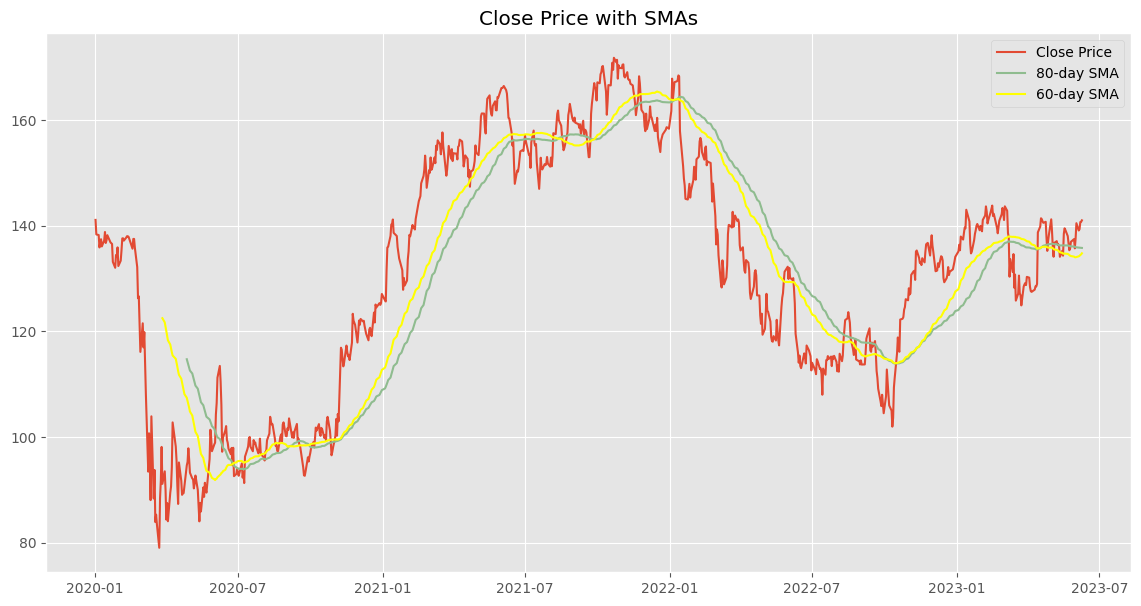

In [4]:
plt.figure(figsize=(14, 7))
plt.plot(df.Close, label='Close Price')

# There are some ideas about colours of lines
# eye-catching for the fast, and more mellow for the slow
plt.plot(df.SlowSMA, label=f"{slow}-day SMA", color="darkseagreen")
plt.plot(df.FastSMA, label=f"{fast}-day SMA", color="yellow")
plt.legend()
plt.title('Close Price with SMAs')
plt.show()

## Signals

To apply our strategy to the data, we will create a `Signal` column which will contain 1 for buy signals (when the fast SMA is above the slow SMA) and -1 for sell signals. Because we are in a *wait* position while we *wait* for the slow SMA to kick-in, we'll fill the Signal column with 0 for those rows. We'll use `where()` for both of these.

In [5]:
# Initialise signal column with zeros
df['Signal'] = 0

# Generate Buy Signal: FastSMA is above the Slow
df["Signal"] = np.where(df.FastSMA > df.SlowSMA, 1, df.Signal)

# Generate Sell Signal: FastSMA is below the Slow
df["Signal"] = np.where(df.FastSMA < df.SlowSMA, -1, df.Signal)

df.Signal.value_counts()
df[slow -1:]

,Open,High,Low,Close,Adj Close,Volume,FastSMA,SlowSMA,Signal
Date,,,,,,,,,
2020-04-27,91.940002,95.629997,91.540001,94.620003,86.477211,22870200,107.425834,114.718750,-1
2020-04-28,97.809998,98.360001,95.029999,95.290001,87.089539,20238900,106.808001,114.146250,-1
2020-04-29,99.080002,99.449997,97.269997,97.860001,89.438362,20462600,106.216167,113.640250,-1
2020-04-30,95.599998,96.839996,94.550003,95.760002,87.519089,19127600,105.557334,113.109375,-1
2020-05-01,93.500000,93.739998,91.839996,93.250000,85.225098,18547700,104.818334,112.576500,-1
...,...,...,...,...,...,...,...,...,...
2023-06-05,140.110001,140.110001,138.130005,139.089996,139.089996,8511900,134.202833,135.855250,-1
2023-06-06,138.679993,140.100006,138.210007,139.339996,139.339996,9329500,134.297667,135.841750,-1
2023-06-07,139.550003,141.270004,138.830002,140.690002,140.690002,9281400,134.455000,135.837375,-1


### Exercise: Blink and you'll miss it

Can you identify on which dates we had a crossover?

In [6]:
# the crossovers are represented by 2 or -2
df[(abs(df.Signal.diff()) == 2)]

,Open,High,Low,Close,Adj Close,Volume,FastSMA,SlowSMA,Signal
Date,,,,,,,,,
2020-06-25,94.349998,98.209999,94.260002,97.959999,89.529770,25743600,94.961833,94.855625,1
2020-09-08,102.980003,103.570000,99.480003,99.919998,92.210968,22108600,98.250167,98.399500,-1
2020-09-30,95.349998,97.199997,95.260002,96.269997,88.842575,16400600,98.527333,98.313125,1
2021-08-13,161.789993,162.160004,159.570007,159.979996,151.834152,8980900,156.474333,156.602500,-1
2021-09-28,167.699997,169.300003,165.660004,166.080002,157.623581,13387900,156.515500,156.366999,1
2022-01-11,168.259995,168.520004,166.309998,167.490005,160.878250,11854100,163.932001,163.998001,-1
2022-10-04,110.610001,112.989998,109.860001,112.769997,110.086479,16013600,114.743167,114.736500,1
2022-11-11,135.190002,136.169998,133.779999,135.300003,133.262070,10704700,116.859167,116.868000,-1
2022-11-14,134.800003,135.729996,133.910004,133.910004,131.893005,11085600,117.113833,117.107375,1


## Backtesting

Backtesting is the process of testing a trading strategy on relevant historical data. We can calculate how it would have performed, had it been applied in the past. The simplest backtest calculates the returns that would have been realised if the strategy was implemented.

First, we create a new column with the signal from the previous day. When we backtest, we have to imagine we're trading in real time. Since our signals are based on close prices, we won't be able to act on them until the following day when the market re-opens. Failing to do this is called *look-ahead bias*.

In [7]:
# Take a look at the day we generated the buy signal
# When could we have acted on it?
print(df.loc["2020-09-15":"2020-09-20"])

# Shift down to avoid look-ahead bias
df['Position'] = df.Signal.shift(1)
df

                  Open        High        Low      Close  Adj Close    Volume  \
Date                                                                            
2020-09-15  102.730003  102.849998  99.139999  99.279999  91.620354  23683000   
2020-09-16   99.430000  101.129997  98.760002  99.699997  92.007942  19270600   
2020-09-17   98.699997   99.339996  97.709999  98.559998  90.955894  18290100   
2020-09-18   97.889999   99.489998  97.440002  98.349998  90.762100  20121600   

              FastSMA    SlowSMA  Signal  
Date                                      
2020-09-15  98.316500  99.112000      -1  
2020-09-16  98.365667  99.239875      -1  
2020-09-17  98.376167  99.274125      -1  
2020-09-18  98.437667  99.236375      -1  


,Open,High,Low,Close,Adj Close,Volume,FastSMA,SlowSMA,Signal,Position
Date,,,,,,,,,,
2020-01-02,139.789993,141.100006,139.259995,141.089996,126.807808,10803700,NaN,NaN,0,NaN
2020-01-03,137.500000,139.229996,137.080002,138.339996,125.134415,10386800,NaN,NaN,0,0.0
2020-01-06,136.559998,138.270004,136.500000,138.229996,125.034927,10259000,NaN,NaN,0,0.0
2020-01-07,137.279999,137.860001,135.820007,135.880005,122.909264,10531300,NaN,NaN,0,0.0
2020-01-08,135.699997,137.580002,135.600006,136.940002,123.868065,9695300,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-06-05,140.110001,140.110001,138.130005,139.089996,139.089996,8511900,134.202833,135.855250,-1,-1.0
2023-06-06,138.679993,140.100006,138.210007,139.339996,139.339996,9329500,134.297667,135.841750,-1,-1.0
2023-06-07,139.550003,141.270004,138.830002,140.690002,140.690002,9281400,134.455000,135.837375,-1,-1.0


Next we calculate the market daily returns normally using `pct_change()`. We then calculate our strategy returns by multiplying our buy/sell position with the market returns. Here is how it works:

- On days when the market gains (+ market return)
    - In the buy position (+) , our strategy gains
    - In the sell position (-), our strategy loses
- On days when the market loses (- market return)
    - In the buy position (+), our strategy loses
    - In the sell position (-), our strategy gains

In [8]:
# Calculating the daily market return (or a buy and hold strategy)
df["MarketDaily"] = df.Close.pct_change()
df["MarketDaily"] = np.where(df.SlowSMA.isna(), 0, df.MarketDaily)

# Calculating the daily return of our crossover strategy
df["StrategyDaily"] = df.Position * df.MarketDaily

df

,Open,High,Low,Close,Adj Close,Volume,FastSMA,SlowSMA,Signal,Position,MarketDaily,StrategyDaily
Date,,,,,,,,,,,,
2020-01-02,139.789993,141.100006,139.259995,141.089996,126.807808,10803700,NaN,NaN,0,NaN,0.000000,NaN
2020-01-03,137.500000,139.229996,137.080002,138.339996,125.134415,10386800,NaN,NaN,0,0.0,0.000000,0.000000
2020-01-06,136.559998,138.270004,136.500000,138.229996,125.034927,10259000,NaN,NaN,0,0.0,0.000000,0.000000
2020-01-07,137.279999,137.860001,135.820007,135.880005,122.909264,10531300,NaN,NaN,0,0.0,0.000000,0.000000
2020-01-08,135.699997,137.580002,135.600006,136.940002,123.868065,9695300,NaN,NaN,0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-05,140.110001,140.110001,138.130005,139.089996,139.089996,8511900,134.202833,135.855250,-1,-1.0,-0.009824,0.009824
2023-06-06,138.679993,140.100006,138.210007,139.339996,139.339996,9329500,134.297667,135.841750,-1,-1.0,0.001797,-0.001797
2023-06-07,139.550003,141.270004,138.830002,140.690002,140.690002,9281400,134.455000,135.837375,-1,-1.0,0.009689,-0.009689


To determine if our strategy would profit or lose, we can calculate the cumulative returns of our strategy for the period. We can then compare it to a *buy & hold* strategy (where we buy at the start of the period and sell at the end), which is represented as the cumulative market returns.

In [9]:
df["MarketReturn"] = (1 + df.MarketDaily).cumprod() - 1
df["StrategyReturn"] = (1 + df.StrategyDaily).cumprod() - 1

df.tail()

,Open,High,Low,Close,Adj Close,Volume,FastSMA,SlowSMA,Signal,Position,MarketDaily,StrategyDaily,MarketReturn,StrategyReturn
Date,,,,,,,,,,,,,,
2023-06-05,140.110001,140.110001,138.130005,139.089996,139.089996,8511900,134.202833,135.855250,-1,-1.0,-0.009824,0.009824,0.533348,1.810365
2023-06-06,138.679993,140.100006,138.210007,139.339996,139.339996,9329500,134.297667,135.841750,-1,-1.0,0.001797,-0.001797,0.536104,1.805314
2023-06-07,139.550003,141.270004,138.830002,140.690002,140.690002,9281400,134.455000,135.837375,-1,-1.0,0.009689,-0.009689,0.550987,1.778134
2023-06-08,140.669998,140.889999,139.479996,140.729996,140.729996,7368100,134.556833,135.814375,-1,-1.0,0.000284,-0.000284,0.551428,1.777345
2023-06-09,140.350006,141.800003,140.210007,141.009995,141.009995,7249100,134.769333,135.787000,-1,-1.0,0.001990,-0.001990,0.554514,1.771819


Let's plot these for a visual representation.

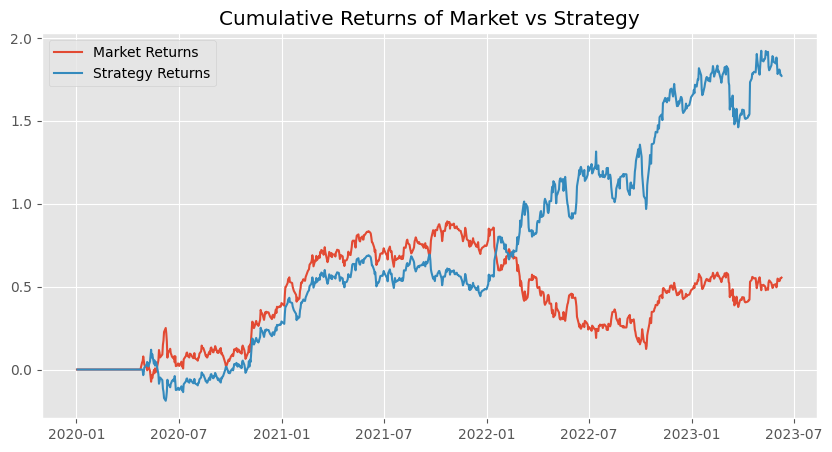

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(df.MarketReturn, label="Market Returns")
plt.plot(df.StrategyReturn, label="Strategy Returns")
plt.legend()
plt.title("Cumulative Returns of Market vs Strategy")
plt.show()

### Exercise: BB Breakout

Implement an Bollinger Bands Breakout strategy and backtest it on JPM.

- First create high and low Bollinger Bands as usual
- Then generate signals as follows:
  - Buy (+1) when the close price crosses above the upper band
    - Hold the position until a signal change
  - Sell (-1) when the close price crosses under the lower band
    - Hold the position until a signal change
- Generate positions
- Calculate the strategy returns and cumulative strategy returns
- Report and plot the cumulative strategy and market returns

**HINT** You can create an empty column by assigning it `np.nan` and propagate a value forwards with `ffill()`.

In [ ]:
# Sample (not model) solution

bolli = df

bolli["sma"] = bolli.Close.rolling(window=20).mean()
bolli["dev"] = bolli.Close.rolling(window=20).std()
bolli["lowband"] = bolli.sma - (2 * bolli.dev)
bolli["highband"] = bolli.sma + (2 * bolli.dev)

bolli["signal"] = np.nan
bolli.loc[bolli.Close > bolli.highband, "signal"] = 1
bolli.loc[bolli.Close < bolli.lowband, "signal"] = -1
bolli.signal = bolli.signal.ffill()
bolli.signal = bolli.signal.fillna(0)

bolli['position'] = bolli.signal.shift()
bolli['marketdaily'] = bolli.Close.pct_change()
bolli["stratret"] = bolli.position * bolli.marketdaily
bolli["strategy"] = (1 + bolli.stratret).cumprod()
bolli["market"] = (1 + bolli.marketdaily).cumprod()
print("Cumulative Strategy Return is", bolli["strategy"].iloc[-1])
print("Market Strategy Return is", bolli["market"].iloc[-1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
ax1.set_title("A Bollinger Bands Breakout")
ax1.plot(bolli.lowband, color="grey")
ax1.plot(bolli.highband, color="grey")
ax1.plot(bolli.Close, label="Price")

ax2.plot(bolli.market, label="Market")
ax2.plot(bolli.strategy, label="Strategy")

ax1.legend()
ax2.legend()

plt.show()